# _littleglyphs_ - finding an unambiguous alphabet

### Setup the environment

Import the project library for glyph generation, classification, plotting, etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [80]:
import littleglyphs as lilg
import littleglyphs.plotting as lilgplt
import littleglyphs.classification as lilgcls
import littleglyphs.examples as lilgex

import importlib
importlib.reload(lilg)
importlib.reload(lilgplt)
importlib.reload(lilgcls)
importlib.reload(lilgex)

<module 'littleglyphs.examples' from '/home/incide/projects/littleglyphs/littleglyphs/examples.py'>

Import the libraries required for this notebook.

In [81]:
import copy
import time

import numpy as np
import scipy
from scipy import signal as scipy_signal
import skimage
import sklearn 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras


Some examples generate data randomly. Seed the random number generator for consistent results.

In [82]:
random_seed = 456
np.random.seed(random_seed)

### Broadly search glyph space

Pre-generate a large glyph alphabet to widely search glyph space for some potentially good candidates.

In [83]:
N_glyphs_in_alphabet = 100

N_bezier_features = 0
N_line_features = 0
N_ellipse_features = 0
N_multipoint_line_features = 0
multipoint_line_feature_N_points = 3
N_multipoint_bezier_features = 1
multipoint_bezier_feature_N_points = 3

N_glyph_permutations = 20
permutation_strength = 0.08

imgsize = 16

N_glyph_raster_distortions = 10
rotat_distort_max = np.pi / 8
shear_distort_max = np.pi / 8
scale_distort_max = 0.25

blur_factor = 1

N_variations_per_glyph = N_glyph_permutations*N_glyph_raster_distortions

time_start = time.time()
print('Generating glyph alphabet and glyph variations... ', end='')

def makeRandomGlyph(category):
    glyph = lilg.Glyph(
        [lilg.FeatureBezierCurve() for count in range(0,N_bezier_features)]+
        [lilg.FeatureLineSegment() for count in range(0,N_line_features)]+
        [lilg.FeatureEllipse() for count in range(0,N_ellipse_features)]+
        [lilg.FeatureMultiPointLineSegment(multipoint_line_feature_N_points) for count in range(0,N_multipoint_line_features)]+
        [lilg.FeatureMultiPointBezierCurve(multipoint_bezier_feature_N_points) for count in range(0,N_multipoint_bezier_features)]
    )
    glyph.set_category(category)
    glyph.randomize_all_features()
    return glyph

glyphs = []
glyph_categories = list(range(0,N_glyphs_in_alphabet))

for category in glyph_categories:
    glyph = makeRandomGlyph(category)
    glyphs.append(glyph)
    
#starter_glyph = makeRandomGlyph(0)    
#for category in glyph_categories:
#    glyph = starter_glyph.permuted(permutation_strength)
#    glyph.set_category(category)
#    glyphs.append(glyph)

glyph_alphabet = lilg.GlyphList(glyphs)

#glyph_alphabet = lilg.examples.MNISTlike_glyph_alphabet()
#N_glyphs_in_alphabet = len(glyph_alphabet)

glyph_permuted_alphabet = glyph_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
distorter = lilg.SequentialDistorter(
    [
        lilg.DistortionRandomAffine(
            rotat_distort_max = rotat_distort_max, 
            shear_distort_max = shear_distort_max,
            scale_distort_max = scale_distort_max
        )
    ]
)
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)


time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/N_glyphs_in_alphabet)+' sec per glyph).')


Generating glyph alphabet and glyph variations... done in 27.814 sec (0.278 sec per glyph).


Visualise the glyphs and show some examples of glyph rasters.

Ground truth glyphs:


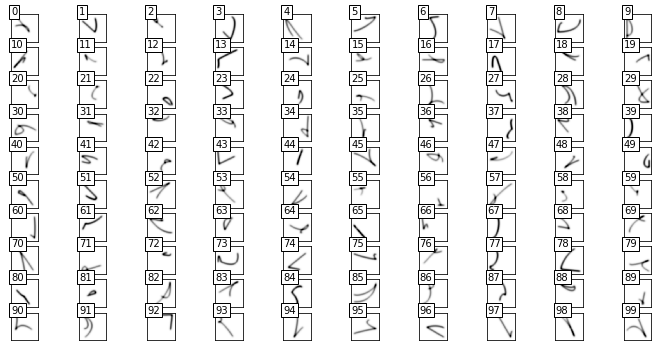

In [84]:
print('Ground truth glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_alphabet,
    N_glyphs_to_show = N_glyphs_in_alphabet, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

Examples of glyph images:


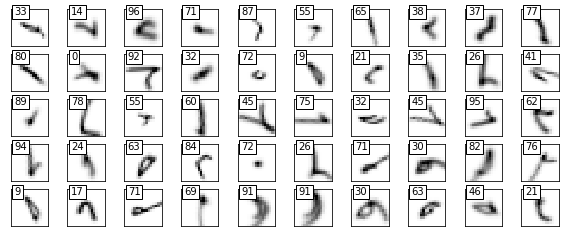

In [85]:
print('Examples of glyph images:')
N_images_to_show = 50

random_indices = np.arange(len(glyph_rasters))
np.random.shuffle(random_indices)
vis_imgs = glyph_rasters[random_indices[0:N_images_to_show]]
vis_categories = glyph_rasters.categories[random_indices[0:N_images_to_show]]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,figsize=(10,4))
plt.show()

### Pre-process the data for categorization

Make a one-hot encoded category correspondence array for the glyph variations.

In [86]:
category_classes, inverse_category_class_indices = np.unique(glyph_rasters.categories, return_inverse=True)
N_classes = len(category_classes)

X = glyph_rasters.rasters
Y = keras.utils.to_categorical(glyph_rasters.categories, num_classes=N_classes)

We have our data ready to be fed to the categorizer. Split it into training, cross-validation, and test sets.

In [87]:
X_train, Y_train, X_cv, Y_cv, X_test, Y_test = lilgcls.split_data_for_learning(
    X, Y, 
    crossval_proportion = 0.2, 
    test_proportion = 0.2, 
    random_seed=random_seed
)
    
print("X_train matrix shape: "+str(X_train.shape)+"; Y_train matrix shape: "+str(Y_train.shape))
print("X_test  matrix shape: "+str(X_test.shape )+"; Y_test  matrix shape: "+str(Y_test.shape ))
print("X_cv    matrix shape: "+str(X_cv.shape   )+"; Y_cv    matrix shape: "+str(Y_cv.shape   ))

X_train matrix shape: (12000, 16, 16); Y_train matrix shape: (12000, 100)
X_test  matrix shape: (4000, 16, 16); Y_test  matrix shape: (4000, 100)
X_cv    matrix shape: (4000, 16, 16); Y_cv    matrix shape: (4000, 100)


### Categorize the glyphs using a CNN

Prepare a CNN model.

In [88]:
keras.backend.clear_session()
model = lilgcls.make_CNN_model(imgsize, N_classes, complexity = 4)

We have our model. Transform the data into a format that can be fed to it, and start training.

In [89]:
X_train_conv = lilgcls.prep_data_for_CNN_model(X_train, imgsize)
X_cv_conv = lilgcls.prep_data_for_CNN_model(X_cv, imgsize)

N_epochs = 10

#from keras.callbacks import ModelCheckpoint
#checkpoint_filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

h = model.fit(
    X_train_conv, Y_train, 
    epochs=N_epochs, batch_size=N_classes*10, 
    verbose=2,
    #callbacks=callbacks_list, 
    validation_data=(X_cv_conv,Y_cv)
)

#from IPython.display import Audio
#Audio('./bell.ogg',autoplay=True)

Train on 12000 samples, validate on 4000 samples
Epoch 1/10
 - 4s - loss: 4.4447 - acc: 0.0473 - val_loss: 4.1405 - val_acc: 0.1312
Epoch 2/10
 - 4s - loss: 3.8385 - acc: 0.1141 - val_loss: 3.4494 - val_acc: 0.2168
Epoch 3/10
 - 3s - loss: 3.3722 - acc: 0.1601 - val_loss: 3.0482 - val_acc: 0.2605
Epoch 4/10
 - 3s - loss: 3.1328 - acc: 0.1902 - val_loss: 2.7711 - val_acc: 0.3210
Epoch 5/10
 - 3s - loss: 2.9475 - acc: 0.2183 - val_loss: 2.5920 - val_acc: 0.3548
Epoch 6/10
 - 3s - loss: 2.8297 - acc: 0.2424 - val_loss: 2.4416 - val_acc: 0.3745
Epoch 7/10
 - 4s - loss: 2.7166 - acc: 0.2655 - val_loss: 2.3227 - val_acc: 0.4010
Epoch 8/10
 - 3s - loss: 2.6264 - acc: 0.2763 - val_loss: 2.2318 - val_acc: 0.4060
Epoch 9/10
 - 3s - loss: 2.5455 - acc: 0.2930 - val_loss: 2.1320 - val_acc: 0.4445
Epoch 10/10
 - 3s - loss: 2.4618 - acc: 0.3117 - val_loss: 2.0465 - val_acc: 0.4475


Show the evolution of training/cross-validation losses and accuracies.

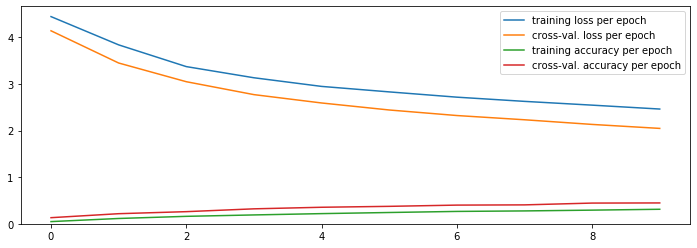

4000/4000 [==============================] - 1s 146us/step
Loss on test set: ~2.00
Accuracy on test set: ~47%


In [90]:
accurs = h.history['acc']
val_accurs = h.history['val_acc']
losses = h.history['loss']
val_losses = h.history['val_loss']
epoch_numbers = h.epoch

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(epoch_numbers, losses, label='training loss per epoch')
plt.plot(epoch_numbers, val_losses, label='cross-val. loss per epoch')
plt.plot(epoch_numbers, accurs, label='training accuracy per epoch')
plt.plot(epoch_numbers, val_accurs, label='cross-val. accuracy per epoch')
ax.set_ylim([0,None])
ax.legend()
plt.show()

X_test_conv = lilgcls.prep_data_for_CNN_model(X_test,imgsize)
loss_and_metrics = model.evaluate(X_test_conv, Y_test, batch_size=128)
print('Loss on test set: ~'+'{0:.2f}'.format(loss_and_metrics[0]))
print('Accuracy on test set: ~'+'{0:.0f}'.format(loss_and_metrics[1]*100)+'%')

Evaluate the model's predictions for the test data.

In [91]:
Y_predicted = model.predict(X_test_conv, batch_size=128)
Y_predicted_class = np.argmax(Y_predicted, axis=1)
Y_predicted_probability = np.max(Y_predicted, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)

Visualise the examples of test data and predictions on test data.

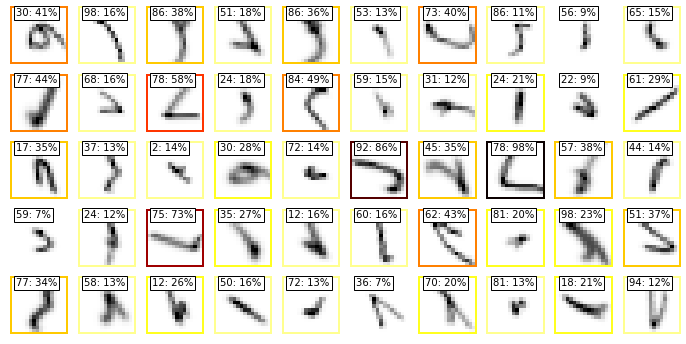

In [92]:
N_images_to_show = 50

vis_imgs = X_test[:N_images_to_show]
vis_categories = Y_predicted_class[:N_images_to_show]
vis_probabilities = Y_predicted_probability[:N_images_to_show]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap = 'hot_r', figsize=(12,6))
plt.show()

### Cull the most ambiguous symbols 

Calculate probabilistic confusion entropy matrix. 

The matrix is basically like a regular confusion matrix, but instead of discretely treating the highest output of the classifier as the output class, it smoothly treats all outputs of the classifier as "surety" of the classifier in each class. This uncovers information about the cases where the classifier works, but is not very sure in its answers.

Each row corresponds to the "true" class. Each column corresponds to the "surety" of the classifier in its output for the column. So, for instance, an element [4,2] corresponds to the average degree of surety with which the classifier says "it belongs to class 2" when it sees an element that in reality belongs to class 4.
Similarly to the case of a regular confusion matrix, a good classifier will have high values of diagonal elements and low values of all other elements.

( Based on doi:10.3390/e15114969 )


Probabilistic confusion entropy matrix:


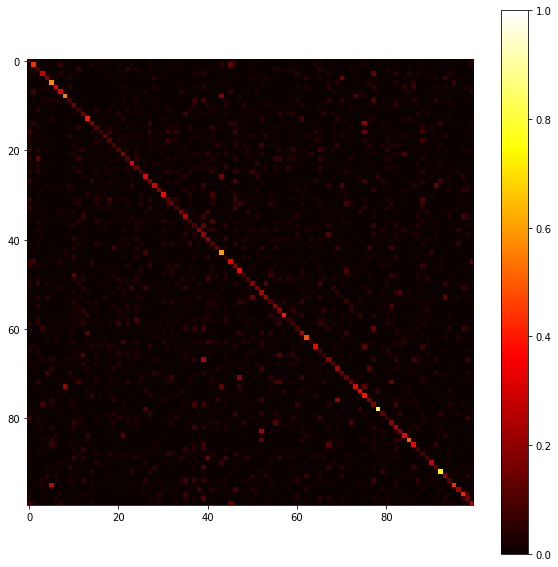

Class with worst performance: 58
Class with best performance:  78


In [93]:
prob_conf_ent_matrix = lilgcls.prob_conf_ent_matrix(Y_test,Y_predicted,N_classes)

worst_class_index = np.diagonal(prob_conf_ent_matrix).argmin()
best_class_index =  np.diagonal(prob_conf_ent_matrix).argmax()

print('Probabilistic confusion entropy matrix:')
#print(np.around(prob_conf_ent_matrix,decimals=3))
plt.figure(figsize = (10,10))
plt.imshow(prob_conf_ent_matrix, vmin=0, vmax=1, cmap='hot')
plt.colorbar()
plt.show()
print('Class with worst performance: '+str(worst_class_index))
print('Class with best performance:  '+str(best_class_index))


Show the worst confusion case.

In [94]:
prob_conf_ent_matrix_nodiag = prob_conf_ent_matrix.copy()
np.fill_diagonal(prob_conf_ent_matrix_nodiag,0)

worst_confusion_index = np.unravel_index(
    np.argmax(prob_conf_ent_matrix_nodiag, axis=None), 
    prob_conf_ent_matrix_nodiag.shape
)
print('Most confused pair: class '
      +str(worst_confusion_index[0])
      +' is being mistaken for class '
      +str(worst_confusion_index[1])
      +' with probability '
      +str(np.around(prob_conf_ent_matrix_nodiag[worst_confusion_index],decimals=3))
     )

Most confused pair: class 95 is being mistaken for class 5 with probability 0.291


Visualise examples of the glyphs corresponding to the worst encountered confusion.

Actual distribution of classes for test data:
[29 47 35 41 36 37 41 40 44 42 34 27 39 38 37 38 47 43 35 41 45 43 46 31
 44 44 41 42 43 36 41 45 45 32 39 44 43 38 42 32 39 32 45 38 31 38 43 33
 49 46 43 41 35 53 40 41 40 42 47 45 42 40 30 45 46 30 44 47 34 34 36 41
 50 43 36 25 44 42 46 43 38 46 37 36 33 45 41 35 32 46 35 32 55 33 47 48
 38 40 39 38]
Distribution of classes for test data as predicted by the classifier:
[ 58  52  61  28  18  56  42  31  45  18  59   9  71  36  14  23   6  23
  21  22  46  54  38  26 101  22  41  37  32  15  53  76  47  12  28  84
  32  37  41  88  81  16  52  62  30  43 102  44  31  33  63  23  60  56
  26  63  94  43   6  54   9  48  32  10  51  49   6  29  17  38  38  31
  62  24  33  41  33  81  51  20   6  83  63  13  24  44  57  13  14  17
  30  15  77  31  24  34  22  58  58  29]
Examples of class 95:


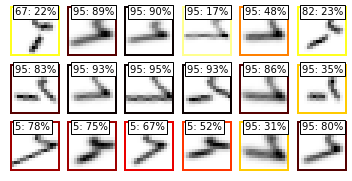

Examples of class 5:


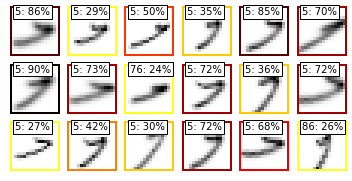

In [95]:
print('Actual distribution of classes for test data:')
print(np.bincount(Y_test_class))
print('Distribution of classes for test data as predicted by the classifier:')
print(np.bincount(Y_predicted_class))

N_images_to_show = 18

print('Examples of class '+str(worst_confusion_index[0])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[0])[0]
vis_indices = vis_indices[:N_images_to_show]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)                            
                            )
plt.show()

print('Examples of class '+str(worst_confusion_index[1])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[1])[0]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,                             
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)
                            )
plt.show()


Cull the alphabet to leave only the least ambiguous symbols. Ambiguity metric is defined as the sum of all confusion probabilities for a particular glyph.

In [96]:
N_survivors = 10

ambiguity_metrics = np.zeros(N_classes)
for i in range(0,N_classes):
#    ambiguity_metrics[i] = np.sum(prob_conf_ent_matrix[i]**2) - prob_conf_ent_matrix[i,i]**2
    ambiguity_metrics[i] = -prob_conf_ent_matrix[i,i]**2
    
best_glyph_indices = np.argpartition(ambiguity_metrics, N_survivors)[:N_survivors]
print(best_glyph_indices)

[ 8 78 85 92 62  5 43  1 95 97]


In [97]:
N_glyphs_in_alphabet = N_survivors
glyph_alphabet = glyph_alphabet.selected(best_glyph_indices)
glyph_alphabet.reset_categories()

Best selected glyphs:


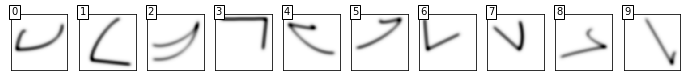

In [98]:
print('Best selected glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_alphabet,
    N_glyphs_to_show = N_survivors, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

### Categorize the glyphs using a CNN

In [168]:
time_start = time.time()
print('Generating new glyph permutations and variations... ', end='')

glyph_permuted_alphabet = glyph_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
distorter = lilg.SequentialDistorter(
    [
        lilg.DistortionRandomAffine(
            rotat_distort_max = rotat_distort_max, 
            shear_distort_max = shear_distort_max,
            scale_distort_max = scale_distort_max
        )
    ]
)
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)
time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/N_glyphs_in_alphabet)+' sec per glyph).')

Generating new glyph permutations and variations... done in 2.933 sec (0.293 sec per glyph).


In [169]:
category_classes, inverse_category_class_indices = np.unique(glyph_rasters.categories, return_inverse=True)
N_classes = len(category_classes)

X = glyph_rasters.rasters
Y = keras.utils.to_categorical(glyph_rasters.categories, num_classes=N_classes)

X_train, Y_train, X_cv, Y_cv, X_test, Y_test = lilgcls.split_data_for_learning(
    X, Y, 
    crossval_proportion = 0.2, 
    test_proportion = 0.2, 
    random_seed=random_seed
)
    
print("X_train matrix shape: "+str(X_train.shape)+"; Y_train matrix shape: "+str(Y_train.shape))
print("X_test  matrix shape: "+str(X_test.shape )+"; Y_test  matrix shape: "+str(Y_test.shape ))
print("X_cv    matrix shape: "+str(X_cv.shape   )+"; Y_cv    matrix shape: "+str(Y_cv.shape   ))

X_train matrix shape: (1200, 16, 16); Y_train matrix shape: (1200, 10)
X_test  matrix shape: (400, 16, 16); Y_test  matrix shape: (400, 10)
X_cv    matrix shape: (400, 16, 16); Y_cv    matrix shape: (400, 10)


In [170]:
keras.backend.clear_session()
model = lilgcls.make_CNN_model(imgsize, N_classes, complexity = 4)

X_train_conv = lilgcls.prep_data_for_CNN_model(X_train, imgsize)
X_cv_conv = lilgcls.prep_data_for_CNN_model(X_cv, imgsize)

N_epochs = 10
h = model.fit(
    X_train_conv, Y_train, 
    epochs=N_epochs, batch_size=N_classes*10, 
    verbose=2,
    #callbacks=callbacks_list, 
    validation_data=(X_cv_conv,Y_cv)
)

#from IPython.display import Audio
#Audio('./bell.ogg',autoplay=True)

Train on 1200 samples, validate on 400 samples
Epoch 1/10
 - 1s - loss: 2.2522 - acc: 0.1675 - val_loss: 2.1602 - val_acc: 0.2525
Epoch 2/10
 - 0s - loss: 2.0827 - acc: 0.2667 - val_loss: 1.9495 - val_acc: 0.3750
Epoch 3/10
 - 0s - loss: 1.9165 - acc: 0.3133 - val_loss: 1.7181 - val_acc: 0.5275
Epoch 4/10
 - 0s - loss: 1.7588 - acc: 0.3550 - val_loss: 1.5222 - val_acc: 0.5975
Epoch 5/10
 - 0s - loss: 1.6217 - acc: 0.4008 - val_loss: 1.3595 - val_acc: 0.7025
Epoch 6/10
 - 0s - loss: 1.5340 - acc: 0.4358 - val_loss: 1.2283 - val_acc: 0.7175
Epoch 7/10
 - 0s - loss: 1.4622 - acc: 0.4575 - val_loss: 1.1442 - val_acc: 0.7150
Epoch 8/10
 - 0s - loss: 1.3896 - acc: 0.4875 - val_loss: 1.0786 - val_acc: 0.7300
Epoch 9/10
 - 0s - loss: 1.3310 - acc: 0.5050 - val_loss: 1.0154 - val_acc: 0.7350
Epoch 10/10
 - 0s - loss: 1.2975 - acc: 0.5275 - val_loss: 0.9486 - val_acc: 0.7700


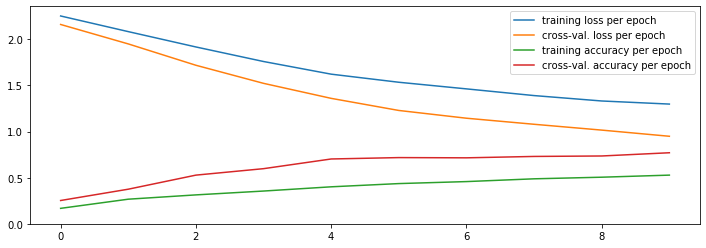

400/400 [==============================] - 0s 174us/step
Loss on test set: ~1.03
Accuracy on test set: ~69%


In [171]:
accurs = h.history['acc']
val_accurs = h.history['val_acc']
losses = h.history['loss']
val_losses = h.history['val_loss']
epoch_numbers = h.epoch

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(epoch_numbers, losses, label='training loss per epoch')
plt.plot(epoch_numbers, val_losses, label='cross-val. loss per epoch')
plt.plot(epoch_numbers, accurs, label='training accuracy per epoch')
plt.plot(epoch_numbers, val_accurs, label='cross-val. accuracy per epoch')
ax.set_ylim([0,None])
ax.legend()
plt.show()

X_test_conv = lilgcls.prep_data_for_CNN_model(X_test,imgsize)
loss_and_metrics = model.evaluate(X_test_conv, Y_test, batch_size=128)
print('Loss on test set: ~'+'{0:.2f}'.format(loss_and_metrics[0]))
print('Accuracy on test set: ~'+'{0:.0f}'.format(loss_and_metrics[1]*100)+'%')

In [172]:
Y_predicted = model.predict(X_test_conv, batch_size=128)
Y_predicted_class = np.argmax(Y_predicted, axis=1)
Y_predicted_probability = np.max(Y_predicted, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)

Probabilistic confusion entropy matrix:


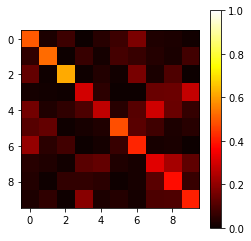

Class with worst performance: 4
Class with best performance:  2


In [173]:
prob_conf_ent_matrix = lilgcls.prob_conf_ent_matrix(Y_test,Y_predicted,N_classes)

worst_class_index = np.diagonal(prob_conf_ent_matrix).argmin()
best_class_index =  np.diagonal(prob_conf_ent_matrix).argmax()

print('Probabilistic confusion entropy matrix:')
#print(np.around(prob_conf_ent_matrix,decimals=3))
plt.figure(figsize = (4,4))
plt.imshow(prob_conf_ent_matrix, vmin=0, vmax=1, cmap='hot')
plt.colorbar()
plt.show()
print('Class with worst performance: '+str(worst_class_index))
print('Class with best performance:  '+str(best_class_index))


In [174]:
prob_conf_ent_matrix_nodiag = prob_conf_ent_matrix.copy()
np.fill_diagonal(prob_conf_ent_matrix_nodiag,0)

worst_confusion_index = np.unravel_index(
    np.argmax(prob_conf_ent_matrix_nodiag, axis=None), 
    prob_conf_ent_matrix_nodiag.shape
)
print('Most confused pair: class '
      +str(worst_confusion_index[0])
      +' is being mistaken for class '
      +str(worst_confusion_index[1])
      +' with probability '
      +str(np.around(prob_conf_ent_matrix_nodiag[worst_confusion_index],decimals=3))
     )

Most confused pair: class 4 is being mistaken for class 7 with probability 0.293


Actual distribution of classes for test data:
[38 37 48 37 53 43 34 43 30 37]
Distribution of classes for test data as predicted by the classifier:
[42 29 44 28 40 50 38 51 30 48]
Examples of class 4:


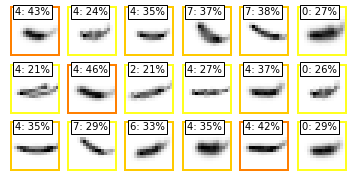

Examples of class 7:


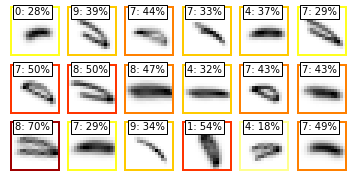

In [175]:
print('Actual distribution of classes for test data:')
print(np.bincount(Y_test_class))
print('Distribution of classes for test data as predicted by the classifier:')
print(np.bincount(Y_predicted_class))

N_images_to_show = 18

print('Examples of class '+str(worst_confusion_index[0])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[0])[0]
vis_indices = vis_indices[:N_images_to_show]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)                            
                            )
plt.show()

print('Examples of class '+str(worst_confusion_index[1])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[1])[0]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,                             
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)
                            )
plt.show()


### Generate new candidates (mutants) from the current glyph alphabet

In [176]:
N_mutants = 5
mutant_permutation_strength = 0.2
glyph_mutant_alphabet = glyph_alphabet.duplicated(N_mutants)
glyph_mutant_alphabet.reset_categories()
glyph_mutant_alphabet = glyph_mutant_alphabet.permuted(mutant_permutation_strength, 1)

In [177]:
time_start = time.time()
print('Generating mutant glyph permutations and variations... ', end='')

glyph_permuted_alphabet = glyph_mutant_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
distorter = lilg.SequentialDistorter(
    [
        lilg.DistortionRandomAffine(
            rotat_distort_max = rotat_distort_max, 
            shear_distort_max = shear_distort_max,
            scale_distort_max = scale_distort_max
        )
    ]
)
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)
time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/(len(glyph_mutant_alphabet)))+' sec per glyph).')

Generating mutant glyph permutations and variations... done in 13.449 sec (0.269 sec per glyph).


Mutant glyphs:


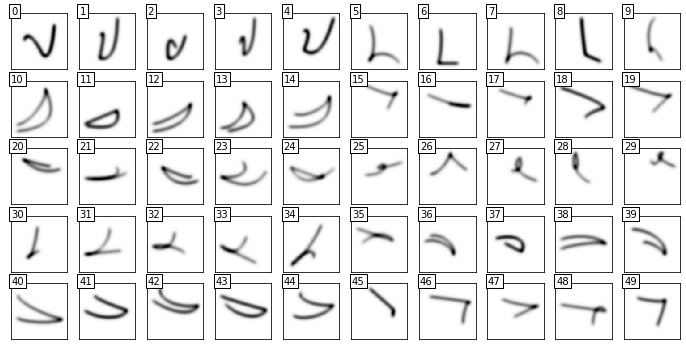

In [178]:
print('Mutant glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_mutant_alphabet,
    N_glyphs_to_show = len(glyph_mutant_alphabet), 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

### Categorize the mutant glyphs using a CNN

In [179]:
category_classes, inverse_category_class_indices = np.unique(glyph_rasters.categories, return_inverse=True)
N_classes = len(category_classes)

X = glyph_rasters.rasters
Y = keras.utils.to_categorical(glyph_rasters.categories, num_classes=N_classes)

X_train, Y_train, X_cv, Y_cv, X_test, Y_test = lilgcls.split_data_for_learning(
    X, Y, 
    crossval_proportion = 0.2, 
    test_proportion = 0.2, 
    random_seed=random_seed
)
    
print("X_train matrix shape: "+str(X_train.shape)+"; Y_train matrix shape: "+str(Y_train.shape))
print("X_test  matrix shape: "+str(X_test.shape )+"; Y_test  matrix shape: "+str(Y_test.shape ))
print("X_cv    matrix shape: "+str(X_cv.shape   )+"; Y_cv    matrix shape: "+str(Y_cv.shape   ))

X_train matrix shape: (6000, 16, 16); Y_train matrix shape: (6000, 50)
X_test  matrix shape: (2000, 16, 16); Y_test  matrix shape: (2000, 50)
X_cv    matrix shape: (2000, 16, 16); Y_cv    matrix shape: (2000, 50)


In [180]:
keras.backend.clear_session()
model = lilgcls.make_CNN_model(imgsize, N_classes, complexity = 4)

X_train_conv = lilgcls.prep_data_for_CNN_model(X_train, imgsize)
X_cv_conv = lilgcls.prep_data_for_CNN_model(X_cv, imgsize)

N_epochs = 10
h = model.fit(
    X_train_conv, Y_train, 
    epochs=N_epochs, batch_size=N_classes*10, 
    verbose=2,
    #callbacks=callbacks_list, 
    validation_data=(X_cv_conv,Y_cv)
)

#from IPython.display import Audio
#Audio('./bell.ogg',autoplay=True)

Train on 6000 samples, validate on 2000 samples
Epoch 1/10
 - 2s - loss: 3.8592 - acc: 0.0480 - val_loss: 3.7573 - val_acc: 0.1105
Epoch 2/10
 - 1s - loss: 3.5912 - acc: 0.1122 - val_loss: 3.3328 - val_acc: 0.2065
Epoch 3/10
 - 1s - loss: 3.1895 - acc: 0.1618 - val_loss: 2.9016 - val_acc: 0.2880
Epoch 4/10
 - 1s - loss: 2.8799 - acc: 0.2007 - val_loss: 2.5859 - val_acc: 0.3460
Epoch 5/10
 - 1s - loss: 2.6844 - acc: 0.2325 - val_loss: 2.3698 - val_acc: 0.4020
Epoch 6/10
 - 1s - loss: 2.5307 - acc: 0.2690 - val_loss: 2.2277 - val_acc: 0.4090
Epoch 7/10
 - 1s - loss: 2.4400 - acc: 0.2817 - val_loss: 2.1113 - val_acc: 0.4380
Epoch 8/10
 - 1s - loss: 2.3638 - acc: 0.2933 - val_loss: 2.0138 - val_acc: 0.4640
Epoch 9/10
 - 1s - loss: 2.2757 - acc: 0.3190 - val_loss: 1.9108 - val_acc: 0.4950
Epoch 10/10
 - 1s - loss: 2.2214 - acc: 0.3302 - val_loss: 1.8658 - val_acc: 0.4895


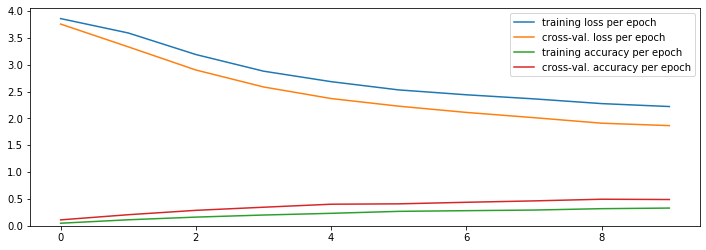

2000/2000 [==============================] - 0s 153us/step
Loss on test set: ~1.79
Accuracy on test set: ~51%


In [181]:
accurs = h.history['acc']
val_accurs = h.history['val_acc']
losses = h.history['loss']
val_losses = h.history['val_loss']
epoch_numbers = h.epoch

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(epoch_numbers, losses, label='training loss per epoch')
plt.plot(epoch_numbers, val_losses, label='cross-val. loss per epoch')
plt.plot(epoch_numbers, accurs, label='training accuracy per epoch')
plt.plot(epoch_numbers, val_accurs, label='cross-val. accuracy per epoch')
ax.set_ylim([0,None])
ax.legend()
plt.show()

X_test_conv = lilgcls.prep_data_for_CNN_model(X_test,imgsize)
loss_and_metrics = model.evaluate(X_test_conv, Y_test, batch_size=128)
print('Loss on test set: ~'+'{0:.2f}'.format(loss_and_metrics[0]))
print('Accuracy on test set: ~'+'{0:.0f}'.format(loss_and_metrics[1]*100)+'%')

In [182]:
Y_predicted = model.predict(X_test_conv, batch_size=128)
Y_predicted_class = np.argmax(Y_predicted, axis=1)
Y_predicted_probability = np.max(Y_predicted, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)

Probabilistic confusion entropy matrix:


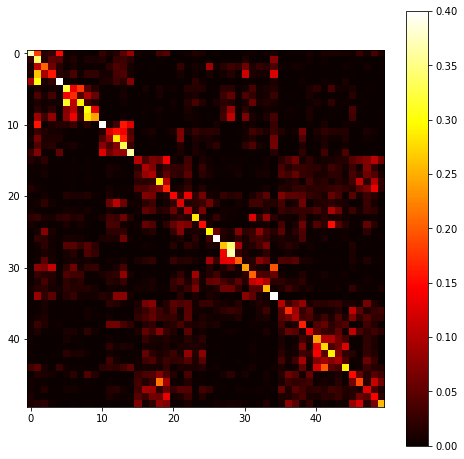

Class with worst performance: 43
Class with best performance:  10


In [183]:
prob_conf_ent_matrix = lilgcls.prob_conf_ent_matrix(Y_test,Y_predicted,N_classes)

worst_class_index = np.diagonal(prob_conf_ent_matrix).argmin()
best_class_index =  np.diagonal(prob_conf_ent_matrix).argmax()

print('Probabilistic confusion entropy matrix:')
#print(np.around(prob_conf_ent_matrix,decimals=3))
plt.figure(figsize = (8,8))
plt.imshow(prob_conf_ent_matrix, vmin=0, vmax=1/N_mutants*2, cmap='hot')
plt.colorbar()
plt.show()
print('Class with worst performance: '+str(worst_class_index))
print('Class with best performance:  '+str(best_class_index))


In [184]:
N_survivors = N_glyphs_in_alphabet

# Glyph ambiguity is defined by the probability of its misclassification to other
#   glyphs, NOT including its "siblings" (glyphs that were generated from its parent).
# Note that including "siblings" in ambiguity may seem like a good idea,
#   but it leads to a particular failure mode:
#   if a glyph was already very different from the rest of the population,
#   then its "children" will likely be good candidates relative to the rest of mutants.
#   This will lead to several "children" passing to the next generation,
#   and if the mutations are not very strong, the children will look alike,
#   thus resulting in a detrimental selection.
ambiguity_metrics = np.zeros(N_classes)
for i in range(0,N_classes):
    i_low = ((i // N_mutants)) * N_mutants
    i_high = ((i // N_mutants)+1) * N_mutants
    ambiguity_metrics[i] = np.sum(prob_conf_ent_matrix[i]) - np.sum(prob_conf_ent_matrix[i,i_low:i_high])
 
print(ambiguity_metrics)    

# The best selected glyphs are the best "children" of each "parent" glyph (one per "parent").
ambiguity_metrics_per_category = np.reshape(ambiguity_metrics,(N_glyphs_in_alphabet,N_mutants))
print(ambiguity_metrics_per_category)    
best_glyph_indices = np.argmax(ambiguity_metrics_per_category, axis=1)
best_glyph_indices = best_glyph_indices + np.arange(0,N_survivors*N_mutants,N_mutants)
print(best_glyph_indices)

[0.50976299 0.27175979 0.55159782 0.54687829 0.23303387 0.35020542
 0.38035626 0.33609738 0.31371886 0.57986688 0.35544302 0.55702725
 0.41153904 0.35560725 0.33311103 0.68482872 0.55363353 0.62585834
 0.47645054 0.63704801 0.89532497 0.77404821 0.67695657 0.72630601
 0.76888606 0.68226211 0.44188365 0.50172195 0.21007493 0.60717719
 0.56286654 0.57436597 0.66146275 0.63249469 0.48876564 0.71933546
 0.68258106 0.69061298 0.68978985 0.76187411 0.27078742 0.31294355
 0.55549849 0.63158392 0.55790793 0.66657955 0.61978723 0.8551503
 0.63730775 0.58970309]
[[0.50976299 0.27175979 0.55159782 0.54687829 0.23303387]
 [0.35020542 0.38035626 0.33609738 0.31371886 0.57986688]
 [0.35544302 0.55702725 0.41153904 0.35560725 0.33311103]
 [0.68482872 0.55363353 0.62585834 0.47645054 0.63704801]
 [0.89532497 0.77404821 0.67695657 0.72630601 0.76888606]
 [0.68226211 0.44188365 0.50172195 0.21007493 0.60717719]
 [0.56286654 0.57436597 0.66146275 0.63249469 0.48876564]
 [0.71933546 0.68258106 0.69061298 

Best selected glyphs:


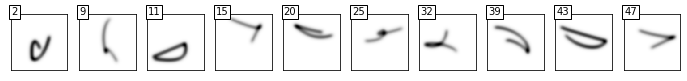

In [185]:
glyph_vis_alphabet = glyph_mutant_alphabet.selected(best_glyph_indices)
print('Best selected glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_vis_alphabet,
    N_glyphs_to_show = len(glyph_vis_alphabet), 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

In [167]:
N_glyphs_in_alphabet = N_survivors
glyph_alphabet = glyph_mutant_alphabet.selected(best_glyph_indices)
glyph_alphabet.reset_categories()